Models are exported in `[store_dir]/models/exported` with file names ending with `.pt`. Each file can be loaded by `saved = torch.load(model_pth)`, and `saved` is a dictionary containing keys `'model'` and `'task'`.

`saved['model']` is a PyTorch module that takes images as inputs and returns logits as outputs. Image pixel values are in $[0, 1]$. `saved['task']` is a string specifying the dataset, can be `'MNIST'`, `'CIFAR10'` or `'CIFAR100'`.

In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15, 'lines.linewidth': 3, 'savefig.dpi': 1200})
colors = plt.get_cmap('Dark2').colors

store_dir, datasets_dir = 'store', 'vision_datasets'

Prepare a list of model groups, with each item `(tag, model_pths, color)`. `tag` is a string for legends, `model_pths` is a list of file names of exported models, `color` is a tuple of length 3.

An example is shown below for the neural-noise project, where 4 groups of models are specified. Adversarial robustness of each group will be compared.

In [2]:
model_pths = {
    (1000, 0): [
        'store/models/exported/FM-LE-1000-[+0.0]_007.pt',
        'store/models/exported/FM-LE-1000-[+0.0]_029.pt',
        'store/models/exported/FM-LE-1000-[+0.0]_041.pt',
        'store/models/exported/FM-LE-1000-[+0.0]_063.pt',
        'store/models/exported/FM-LE-1000-[+0.0]_085.pt',
    ],
    (20, -1): [
        'store/models/exported/FM-LE-20-[-1.0]_063.pt',
        'store/models/exported/FM-LE-20-[-1.0]_085.pt',
    ],
    (20, 0): [
        'store/models/exported/FM-LE-20-[+0.0]_007.pt',
        'store/models/exported/FM-LE-20-[+0.0]_029.pt',
        'store/models/exported/FM-LE-20-[+0.0]_063.pt',
        'store/models/exported/FM-LE-20-[+0.0]_085.pt',
    ],
    (20, 1): [
        'store/models/exported/FM-LE-20-[+1.0]_029.pt',
        'store/models/exported/FM-LE-20-[+1.0]_063.pt',
        'store/models/exported/FM-LE-20-[+1.0]_085.pt',
    ],
}

groups = [
    ('baseline', model_pths[(1000, 0)], colors[0]),
    (r'$\alpha=-1$', model_pths[(20, -1)], colors[1]),
    (r'$\alpha=0$', model_pths[(20, 0)], colors[2]),
    (r'$\alpha=1$', model_pths[(20, 1)], colors[3]),
]

Summarizing the adversarial attack results by `python -m roarena.attack`. Boundary attack that finds minimal adversarial attacks are performed for each image batch, and multiple random seeds are used to find the minimum attack. Distributions of minimum adversarial sizes are gathered in the form of percentiles.

In [3]:
from roarena.attack import AttackJob

attack_job = AttackJob(store_dir, datasets_dir)
dist_percentiles = {
    'L2': [],
    'LI': [],
}
for _, _model_pths, _ in groups:
    for metric in ['L2', 'LI']:
        _, _dist_percentiles = attack_job.summarize(_model_pths, metric=metric, max_batch_num=10)
        dist_percentiles[metric].append(_dist_percentiles)

/foolbox/foolbox/attacks/brendel_bethge.py:624: UserWarning: At the first initialisation the optimizer needs to be compiled. This may take between 20 to 60 seconds.
  warnings.warn(


Percentiles for each model group are used for plotting attacking success rate as a function of adversarial size. The solid lines are the average over models within each group, and the shaded area is the standard deviation.

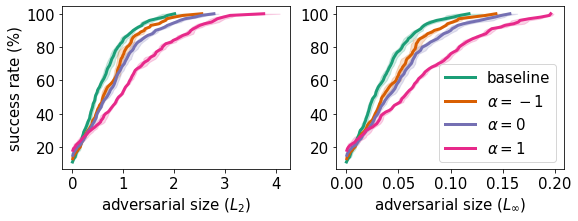

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
for ax, metric in zip(axes, ['L2', 'LI']):
    attack_job.plot_comparison(ax, groups, dist_percentiles[metric])
    ax.set_xlabel(r'adversarial size ({})'.format(r'$L_2$' if metric=='L2' else r'$L_\infty$'))
axes[0].get_legend().remove()
axes[1].set_ylabel(None)
plt.show()